In [ ]:
#default_exp filter

In [ ]:
#hide
import sys, os
from pathlib import Path

# Insert in Path Project Directory
sys.path.insert(0, str(Path().cwd().parent))

# Filtragem
> Este módulo concentra funções auxiliares específicas que filtram os dados do banco com campos e formatação de interesse para aplicações específicas como o [appAnalise](https://github.com/EricMagalhaesDelgado/appAnalise) por exemplo.

In [ ]:
#export
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from anateldb.query import *
from anateldb.constants import console, APP_ANALISE
from fastcore.test import *
from fastcore.script import call_parse, Param, store_true
from pyarrow import ArrowInvalid
from rich import print

In [ ]:
#export
def bump_version(version, part=2):
    version = version.split('.')
    version[part] = str(int(version[part]) + 1)
    for i in range(part+1, 3): version[i] = '0'
    return '.'.join(version)

In [ ]:
#export
@call_parse
def formatar_db(
    path: Param("Pasta onde salvar os arquivos", str),
    up_stel: Param("Atualizar a base do Stel", store_true) = False, 
    up_radcom: Param("Atualizar a base do Radcom", store_true) = False,
    up_mosaico: Param("Atualizar a base do Mosaico", store_true) = False,
) -> None:
    dest = Path(path)
    dest.mkdir(parents=True, exist_ok=True)
    time = datetime.today().strftime("%d/%m/%Y %H:%M:%S")
    console.print(":scroll:[green]Lendo as bases de dados...")
    rd = read_base(path, up_stel, up_radcom, up_mosaico)
    rd['Validade_RF'] = rd.Validade_RF.astype('string').fillna('')
    rd['Data_Ato'] = rd.Data_Ato.astype('string').fillna('')
    rd['Status'] = rd.Status.astype('string')
    rd['Classe'] = rd.Classe.astype('string')
    rd.loc[rd['Status'] != '', 'Status'] = rd.loc[rd['Status'] != '', 'Status'] + ", " \
        + rd.loc[rd['Status'] != '', 'Classe']
    rd.loc[rd['Status'].isna(), 'Status'] = rd.loc[rd['Status'].isna(), 'Num_Serviço'].astype('string')

    rd["Descrição"] = (
        rd.Status.astype('string').fillna('-')
        + ", "
        + rd.Entidade.astype('string').fillna('-').str.title()
        + " ("
        + rd.Fistel.astype('string').fillna('-')
        + ", "
        + rd["Número_da_Estação"].astype('string').fillna('-')
        + "), "
        + rd.Município.astype('string').fillna('-')
        + "/"
        + rd.UF.astype('string').fillna('-')
    )

    export_columns = [
        "Frequência",
        "Latitude",
        "Longitude",
        "Descrição",
        "Num_Serviço",
        "Número_da_Estação",
        "Classe_Emissão",
        "Largura_Emissão",
        "Num_Ato",
        "Data_Ato",
        "Validade_RF",
    ]
    rd = rd.loc[:, export_columns]
    df_optimize(rd, exclude=['Frequência'])
    rd.columns = APP_ANALISE
    console.print(":card_file_box:[green]Salvando os arquivos...")
    d = json.loads((dest / 'VersionFile.json').read_text())
    try:
        cache = pd.read_feather(f"{dest}/AnatelDB.fth")
    except (ArrowInvalid, FileNotFoundError):
        cache = pd.DataFrame()
    
    if not rd.equals(cache):
        console.print(":new: [green] A base de dados mudou desde a última atualização! Salvando o novo arquivo e atualizando a versão")
        date = pd.DataFrame(columns=[time])
        try:
            rd.to_feather(Path(f"{dest}/AnatelDB.fth").open('bw'))
        except ArrowInvalid:
            Path(f"{dest}/AnatelDB.fth").unlink()
        with pd.ExcelWriter(f"{dest}/AnatelDB.xlsx") as workbook:
            date.to_excel(workbook, sheet_name="ExtractDate", index=False)
            rd.to_excel(workbook, sheet_name="DataBase", index=False)
        d['anateldb']['Version'] = bump_version(d['anateldb']['Version'])
    else:
        console.print(":recycle: [green] A base de dados não mudou desde a última atualização, a versão não será atualizada, somente a data de verificação")


    console.print("Sucesso :zap:")    
    d['anateldb']['ReleaseDate'] = datetime.today().strftime('%d/%m/%Y')
    json.dump(d, (dest / 'VersionFile.json').open('w'))

In [ ]:
pasta = Path(r'G:\Meu Drive\data\AnatelDatabase')

In [ ]:
df = pd.read_excel(pasta / 'base.xlsx')

In [ ]:
df.to_feather(pasta / 'base.fth')

In [ ]:
if not pasta.exists():
    import subprocess
    result = subprocess.run(['git', 'clone', 'https://github.com/ronaldokun/AnatelDatabase.git'])
    pasta = Path.cwd() / 'AnatelDatabase'

In [ ]:
d = formatar_db(pasta, False, False, False)

🌤  Baixando o Plano Básico das Estações...

📦 Consolidando as bases de dados...

Kbô 🧛

🏆 Base Consolidada. Salvando os arquivos...

In [ ]:
base = read_base(pasta)

In [ ]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884185 entries, 0 to 884184
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Frequência         884185 non-null  float64 
 1   Num_Serviço        884185 non-null  int16   
 2   Status             884185 non-null  category
 3   Classe             881622 non-null  category
 4   Entidade           884166 non-null  category
 5   Fistel             884185 non-null  int64   
 6   Número_da_Estação  884185 non-null  int32   
 7   Município          884180 non-null  category
 8   UF                 884183 non-null  category
 9   Latitude           884185 non-null  float32 
 10  Longitude          884185 non-null  float32 
 11  Validade_RF        876022 non-null  category
 12  Num_Ato            871637 non-null  float32 
 13  Data_Ato           13798 non-null   category
 14  Classe_Emissão     852215 non-null  category
 15  Largura_Emissão    852215 non-null

In [ ]:
base.Num_Serviço.value_counts()

19     635589
53     134004
46      36714
604     14582
11      14412
801     10243
800      9455
125      5533
231      4910
35       4456
230      4078
507      2075
124      1334
205      1144
17        992
78        969
247       904
79        526
33        372
64        237
108       186
12        167
248       148
27         40
805        29
167        21
29         10
26         10
132         5
15          2
Name: Num_Serviço, dtype: int64

In [ ]:
base.head()

,Frequência,Num_Serviço,Status,Classe,Entidade,Fistel,Número_da_Estação,Município,UF,Latitude,Longitude,Validade_RF,Num_Ato,Data_Ato,Classe_Emissão,Largura_Emissão
0,0.0280,19,L,OP,FURNAS CENTRAIS ELETRICAS S A,01030052263,1557670,Nova Iguaçu,RJ,-22.662777,-43.476387,2033-08-17,-1,,J9E,8K00
1,0.0285,19,L,OP,COMPANHIA DE GERAÇÃO E TRANSMISSÃO DE ENERGIA ...,50420217282,1494686,Joinville,SC,-26.292500,-48.887222,2025-08-31,-1,,R3E,2K50
2,0.0300,19,L,OP,FURNAS CENTRAIS ELETRICAS S A,01030052263,859761,Rio de Janeiro,RJ,-22.926666,-43.264999,2033-08-17,-1,,J3E,500H
3,0.0300,19,L,OP,FURNAS CENTRAIS ELETRICAS S A,01030052263,859966,Araporã,MG,-18.410000,-49.099998,2033-08-17,-1,,J3E,1K00
4,0.0300,19,L,OP,FURNAS CENTRAIS ELETRICAS S A,01030052263,859753,Campinas,SP,-22.774166,-47.004444,2033-08-17,-1,,J3E,1K00


In [ ]:
base[(base.Num_Serviço == 231 ) & ( base.UF == 'TO')]

,Frequência,Num_Serviço,Status,Classe,Entidade,Fistel,Número_da_Estação,Município,UF,Latitude,Longitude,Validade_RF,Num_Ato,Data_Ato,Classe_Emissão,Largura_Emissão
16061,87.5,231,RADCOM,2-H,ASSOCIACAO TUPIRATINS DE APOIO A EDUCACAO CULT...,50412617331,1002645090,Tupiratins,TO,-8.396667,-48.115002,,-1,,NaN,NaN
16473,87.9,231,RADCOM,P-A,ASSOCIACAO RADIO COMUNITARIA JOVEM FM,50406005931,692246991,Arraias,TO,-12.933333,-46.935276,,-1,,NaN,NaN
16474,87.9,231,RADCOM,3-M,ASSOCIACAO DOS PRODUTORES RURAIS DO VALE DO RI...,50404351344,690563515,Aparecida do Rio Negro,TO,-9.955277,-47.977779,,-1,,NaN,NaN
16475,87.9,231,RADCOM,3-M,ASSOCIACAO COMUNITARIA DE ANANAS,50012407437,682604879,Ananás,TO,-6.364444,-48.074444,,-1,,NaN,NaN
16476,87.9,231,RADCOM,3-M,ASSOCIACAO DE RADIODIFUSAO COMUNITARIA DE ABRE...,50409204404,1001385800,Abreulândia,TO,-9.622222,-49.155834,,-1,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23581,104.9,231,RADCOM,P-A,ASSOCIACAO DE RADIODIFUSAO E CULTURA DE AURORA,50406618518,693076852,Aurora do Tocantins,TO,-12.713611,-46.411388,,-1,,NaN,NaN
23582,104.9,231,RADCOM,P-M,ASSOCIACAO DE MORADORES DO BAIRRO BOM JESUS,50406069158,692427864,Axixá do Tocantins,TO,-5.621111,-47.775002,,-1,,NaN,NaN
23583,104.9,231,RADCOM,3-B,ASSOC. DE MORADORES DA COMUNIDADE NOSSA SENHOR...,50013433644,683555910,Babaçulândia,TO,-7.204722,-47.755554,,-1,,NaN,NaN
23584,104.9,231,RADCOM,1-K,ASSOCIAÇÃO RÁDIO COMUNITÁRIA BARROLÂNDIA FM,50409023795,1010073882,Barrolândia,TO,-9.833333,-48.723888,,-1,,NaN,NaN


In [ ]:
base.Status.unique()

['L', 'AM-C7', 'AM-C3', 'AM-C1', 'AM-C2', ..., 'FM-C7', 'FM-C4', 'FM-C1', 'FM-C3', 'TV-C98']
Length: 18
Categories (18, object): ['AM-C1', 'AM-C2', 'AM-C3', 'AM-C4', ..., 'TV-C3', 'TV-C4', 'TV-C7', 'TV-C98']

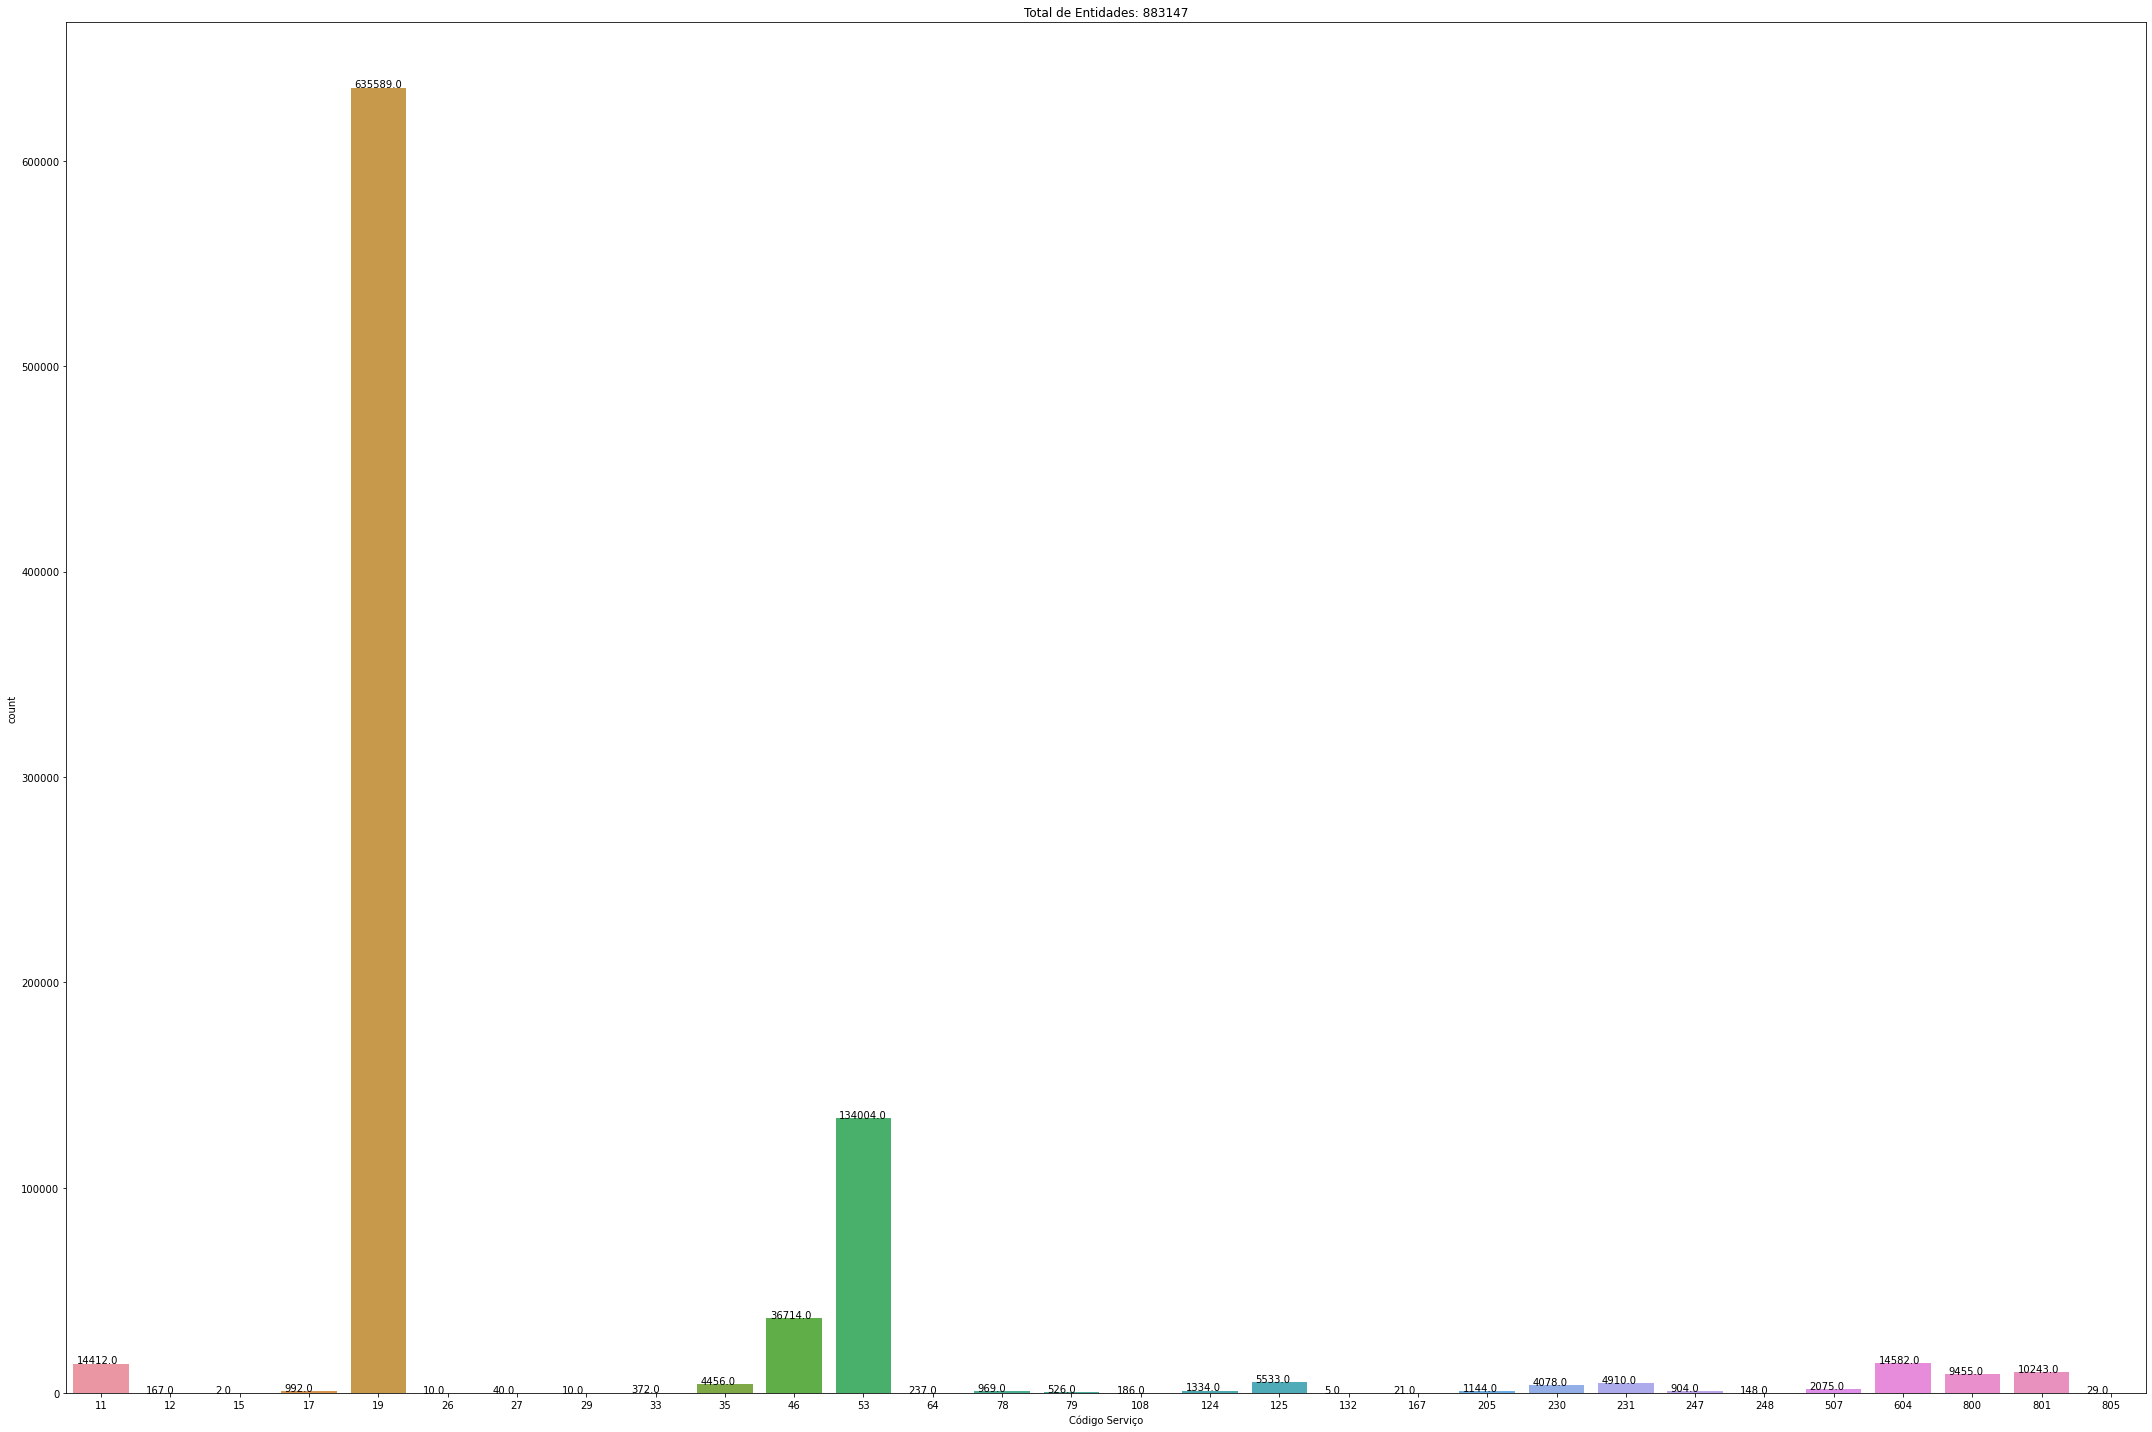

In [ ]:
ax = sns.countplot(x="Num_Serviço", data=base)

plt.rcParams["figure.figsize"] = [30, 20]
plt.rcParams["figure.autolayout"] = True

for p in ax.patches:
    ax.annotate('{:.1f}'.format(int(p.get_height())), (p.get_x()+0.05, p.get_height()+0.02))
    
plt.title(f"Total de Entidades: {base.shape[0]}")
plt.xlabel("Código Serviço")

plt.savefig("Stats.png")

In [ ]:
d = pd.read_feather(pasta / 'AnatelDB.fth')

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886420 entries, 0 to 886419
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Frequency    886420 non-null  float64 
 1   Latitude     886420 non-null  float32 
 2   Longitude    886420 non-null  float32 
 3   Description  886420 non-null  string  
 4   Service      886420 non-null  int32   
 5   Station      886420 non-null  int32   
 6   Class        884318 non-null  category
 7   BW           884318 non-null  category
 8   ActNumber    873511 non-null  category
 9   ActDate      886420 non-null  string  
 10  ValRF        886420 non-null  string  
dtypes: category(3), float32(2), float64(1), int32(2), string(3)
memory usage: 45.1 MB


In [ ]:
n = d.loc[(d.Description.isna()) & (d.Station != -1), 'Station'].index

In [ ]:
d.loc[n]

,Frequency,Latitude,Longitude,Description,Service,Station,Class,BW,ActNumber,ActDate,ValRF


In [ ]:
d.loc[d.Station == 1012545129]

,Frequency,Latitude,Longitude,Description,Service,Station,Class,BW,ActNumber,ActDate,ValRF
20445,103.3,-29.639999,-51.090561,"FM-C4, A2, Radio Progresso Ltda (50419207295, ...",230,1012545129,,,1778,,2023-11-01


In [ ]:
from nbdev.export import notebook2script; notebook2script()

Converted constants.ipynb.
Converted filter.ipynb.
Converted index.ipynb.
Converted queries.ipynb.
